In [1]:
!git clone https://github.com/amnghd/Persian_poems_corpus.git

Cloning into 'Persian_poems_corpus'...
remote: Enumerating objects: 159, done.
remote: Total 159 (delta 0), reused 0 (delta 0), pack-reused 159
Receiving objects: 100% (159/159), 45.21 MiB | 19.20 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 10.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import csv
import os
import re
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BasicTokenizer
from transformers import TFBertModel, TFBertPreTrainedModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample

import transformers
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

In [4]:
normalized_path ='/content/Persian_poems_corpus/normalized/'
my_poets = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
dataset_df = pd.DataFrame(columns = ['poems', 'label' , 'counts'])
poems=[]
labels=[]
len_Lines=[]
counts=[]
l=[]
for i in range(len(my_poets)):
  file1 = open(normalized_path + my_poets[i] + '_norm.txt', 'r')
  Lines = file1.readlines()
  c = 1
  for Line in Lines:
    Line = Line.strip('\n')
    Line = Line.strip('\t')
    if len(Line.split())>3:
      poems.append(Line)
      labels.append(str(i))
      counts.append(c)
      l.append(len(Line.split()))
      c+=1

dataset_df['label'] = labels
dataset_df['poems'] = poems
dataset_df['counts'] = counts

In [5]:
for i in range(10):
  len_Lines.append(len(dataset_df.loc[dataset_df['label']==str(i)]))

In [6]:
np.max(l)

18

In [7]:
np.min(len_Lines)

9430

In [8]:
dataset_df.head()

,poems,label,counts
0,با نصرت و فتح و ظفر و دولت والا,0,1
1,بنگر علم شاه جهان بر سر بالا,0,2
2,لشکر شده آسوده و ترمذ شده ایمن,0,3
3,نصرت شده پیوسته و دولت شده والا,0,4
4,فتح آمده و تهنیت آورده جهان را,0,5


In [9]:
#create balance dataset
dataset_df_2 = dataset_df.loc[(dataset_df['counts'] <= np.min(len_Lines))]
dataset_df_2 =dataset_df_2.reset_index()
dataset_df_2.head()

,index,poems,label,counts
0,0,با نصرت و فتح و ظفر و دولت والا,0,1
1,1,بنگر علم شاه جهان بر سر بالا,0,2
2,2,لشکر شده آسوده و ترمذ شده ایمن,0,3
3,3,نصرت شده پیوسته و دولت شده والا,0,4
4,4,فتح آمده و تهنیت آورده جهان را,0,5


In [10]:
len(dataset_df_2)

94300

In [11]:
dataset = dataset_df_2[['poems', 'label']]
dataset.head()

,poems,label
0,با نصرت و فتح و ظفر و دولت والا,0
1,بنگر علم شاه جهان بر سر بالا,0
2,لشکر شده آسوده و ترمذ شده ایمن,0
3,نصرت شده پیوسته و دولت شده والا,0
4,فتح آمده و تهنیت آورده جهان را,0


In [12]:
dataset['Labels'] = dataset['label'].map({'0': 0,'1': 1,'2': 2,'3': 3,'4': 4, '5':5, '6':6, '7':7, '8':8, '9':9})
dataset = dataset.drop(["label"], axis=1)

dataset.head()

<ipython-input-12-a85f7d74aca2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Labels'] = dataset['label'].map({'0': 0,'1': 1,'2': 2,'3': 3,'4': 4, '5':5, '6':6, '7':7, '8':8, '9':9})


,poems,Labels
0,با نصرت و فتح و ظفر و دولت والا,0
1,بنگر علم شاه جهان بر سر بالا,0
2,لشکر شده آسوده و ترمذ شده ایمن,0
3,نصرت شده پیوسته و دولت شده والا,0
4,فتح آمده و تهنیت آورده جهان را,0


In [13]:

#shuffling
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head(20)

,poems,Labels
0,دیده ندارد که دل به مهر نبسته ست,8
1,رشته تسبیح اگر بگسست معذورم بدار,5
2,دگر به یار جفاکار دل منه سعدی,8
3,در دامن مادر است پنداری,2
4,ز رعنایان نازک دل چه خیزد,1
5,محو در محو و فنا اندر فناست,1
6,که شنید عشقی که بلا نباشد,6
7,تا چو کلیمی تو و دینت عصاست,7
8,زمانه نعره زد چون غول کانا,2
9,بحق بسته باشد دل غیب بین را,6


In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [15]:
labels = tf.keras.utils.to_categorical(dataset["Labels"].values, num_classes=10)

In [16]:
labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [17]:
dataset

,poems,Labels
0,دیده ندارد که دل به مهر نبسته ست,8
1,رشته تسبیح اگر بگسست معذورم بدار,5
2,دگر به یار جفاکار دل منه سعدی,8
3,در دامن مادر است پنداری,2
4,ز رعنایان نازک دل چه خیزد,1
...,...,...
94295,چه ذوق از ذکر پیدا آید آن را,8
94296,صورتی نیست در همه ارتنگ,3
94297,خم و شکن همه بر عارض و جبین دارد,0
94298,این سعادت بسعی می نشود,6


In [18]:
MAX_LENGTH = 128

In [19]:
def convert_data_into_input_example(df, ids, masks,tokenizer):
    for i in range(len(df)):
      tokenized_poem = tokenizer.encode_plus(
          dataset.loc[i,'poems'],
          max_length=MAX_LENGTH,
          truncation = True,
          padding = 'max_length', 
          add_special_tokens = True,
          return_tensors = 'tf'
      )
      ids[i,:] = tokenized_poem.input_ids
      masks[i,:] = tokenized_poem.attention_mask
    return ids, masks

In [20]:
X_input_ids = np.zeros((len(dataset), MAX_LENGTH))
X_attention_masks = np.zeros((len(dataset), MAX_LENGTH))

In [21]:
X_input_ids, X_attention_masks = convert_data_into_input_example(dataset, X_input_ids, X_attention_masks, tokenizer)

In [22]:
X_input_ids

array([[  101., 65453., 57179., ...,     0.,     0.,     0.],
       [  101., 55202.,   766., ...,     0.,     0.,     0.],
       [  101.,   771., 29255., ...,     0.,     0.,     0.],
       ...,
       [  101.,   770., 10700., ...,     0.,     0.,     0.],
       [  101., 10641.,   775., ...,     0.,     0.,     0.],
       [  101., 13044.,   764., ...,     0.,     0.,     0.]])

In [23]:
labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [24]:
final_dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attention_masks, labels))

In [25]:
def DatsetMapFunc(input_ids, attn_masks, labels):
  return {
      'input_ids':input_ids,
      'attention_mask': attn_masks
  }, labels

In [26]:
final_dataset = final_dataset.map(DatsetMapFunc)

In [27]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int((ds_size//BATCH_SIZE)* train_split ) #int(train_split * ds_size)  
    val_size = int((ds_size//BATCH_SIZE)* val_split )    #int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [28]:
BATCH_SIZE= 32
final_dataset = final_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(final_dataset, len(dataset))

In [29]:
len(train_dataset)

2356

###### select 1000 poem for Perplexity


In [30]:
import random
randomlist = random.sample(range(0, len(dataset)), 1000)
print(randomlist)

[16721, 29470, 122, 3255, 39405, 36976, 54742, 19189, 82312, 2850, 26082, 91254, 28474, 72553, 78839, 37754, 7947, 24817, 72187, 44641, 27877, 38392, 17617, 70034, 90993, 66954, 43178, 24599, 79416, 55095, 23343, 27403, 3044, 32004, 10115, 69076, 23012, 75456, 75004, 38294, 52399, 49441, 9480, 1876, 70816, 28983, 44657, 10501, 52096, 7286, 53762, 33284, 55806, 15, 40776, 45217, 28140, 45173, 58585, 58874, 30415, 10743, 43881, 81149, 8602, 19565, 87087, 9671, 85753, 41251, 48985, 39173, 25785, 19614, 27588, 6105, 46603, 70818, 26376, 33083, 38430, 7890, 14734, 8398, 90237, 49167, 39355, 13001, 35136, 61506, 52480, 87873, 74869, 38208, 94083, 71235, 9933, 31680, 90795, 76748, 67173, 87925, 18784, 63255, 39586, 39404, 57845, 14857, 46519, 38745, 58756, 950, 4519, 5084, 28061, 2462, 27413, 17009, 73340, 2389, 17575, 5912, 85911, 47565, 4395, 25816, 65420, 92414, 16232, 49180, 86181, 35475, 84695, 65371, 91751, 80719, 31930, 23526, 3632, 1809, 50957, 45586, 50095, 15762, 88618, 57415, 15914

In [31]:
my_1000_samples = dataset.iloc[randomlist]

In [32]:
my_X_input_ids = np.zeros((len(my_1000_samples), MAX_LENGTH))
my_X_attention_masks = np.zeros((len(my_1000_samples), MAX_LENGTH))

In [33]:
my_X_input_ids, my_X_attention_masks = convert_data_into_input_example(my_1000_samples, my_X_input_ids, my_X_attention_masks, tokenizer)

In [34]:
my_X_input_ids

array([[  101., 65453., 57179., ...,     0.,     0.,     0.],
       [  101., 55202.,   766., ...,     0.,     0.,     0.],
       [  101.,   771., 29255., ...,     0.,     0.,     0.],
       ...,
       [  101., 10383., 11330., ...,     0.,     0.,     0.],
       [  101., 17534., 42445., ...,     0.,     0.,     0.],
       [  101.,   817., 47559., ...,     0.,     0.,     0.]])

In [35]:
my_labels = tf.keras.utils.to_categorical(my_1000_samples["Labels"].values, num_classes=10)
my_labels

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
final_my_1000_samples = tf.data.Dataset.from_tensor_slices((my_X_input_ids, my_X_attention_masks, my_labels))

In [37]:
def DatsetMapFunc(input_ids, attn_masks, labels):
  return {
      'input_ids':input_ids,
      'attention_mask': attn_masks
  }, labels

In [38]:
final_my_1000_samples = final_my_1000_samples.map(DatsetMapFunc)

In [39]:
final_my_1000_samples

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(128,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(128,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float32, name=None))>

In [40]:
BATCH_SIZE= 32
final_my_1000_samples = final_my_1000_samples.batch(BATCH_SIZE, drop_remainder=True)

In [41]:
len(final_my_1000_samples)

31

## freeze BERT model

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_model.trainable = False

In [ ]:
bert_model.summary(())

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
Total params: 177,853,440
Trainable params: 0
Non-trainable params: 177,853,440
_________________________________________________________________


In [ ]:
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'input_ids', dtype= 'int32')
attention_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'attention_mask', dtype= 'int32')
bert_embeds = bert_model(input_ids, attention_mask = attention_masks)[1]

intermeiate_layer = tf.keras.layers.Dense(512, activation='relu', name = 'intermeiate_layer')(bert_embeds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(intermeiate_layer)
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
EPOCHS = 5
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = EPOCHS)

Epoch 1/5
2356/2356 [==============================] - 761s 320ms/step - loss: 2.2774 - accuracy: 0.1433 - val_loss: 2.2471 - val_accuracy: 0.1749
Epoch 2/5
2356/2356 [==============================] - 751s 319ms/step - loss: 2.2353 - accuracy: 0.1819 - val_loss: 2.2056 - val_accuracy: 0.2104
Epoch 3/5
2356/2356 [==============================] - 752s 319ms/step - loss: 2.2075 - accuracy: 0.1956 - val_loss: 2.1801 - val_accuracy: 0.2192
Epoch 4/5
2356/2356 [==============================] - 752s 319ms/step - loss: 2.1858 - accuracy: 0.2082 - val_loss: 2.1585 - val_accuracy: 0.2256
Epoch 5/5
2356/2356 [==============================] - 752s 319ms/step - loss: 2.1705 - accuracy: 0.2120 - val_loss: 2.1385 - val_accuracy: 0.2344


In [ ]:
model.save('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_a') 

#### evaluation results

In [ ]:
preds = model.predict(test_dataset)
Y_pred_labels = preds.argmax(axis=1)
data, labels = tuple(zip(*test_dataset))
Y_test=[]
for i in range(len(labels)):
  for j in range(32):
    Y_test.append(labels[i][j])


Y_test_labels=np.zeros_like(Y_pred_labels)
ind=0
for t in Y_test:
  Y_test_labels[ind] = (t.numpy()).argmax()
  ind+=1

296/296 [==============================] - 82s 266ms/step


[[200  72  24  54  93  32  78 255 159   0]
 [179  94  33  59  74  24  62 238 164   6]
 [166  88  26  50  95  33  65 227 161   7]
 [162  94  29  60 107  26  61 260 200   9]
 [163  84  27  55 110  30  72 258 144   9]
 [183  84  29  50  93  29  77 243 177   4]
 [184  91  31  60  86  28  62 248 193   3]
 [164  79  42  54  96  28  50 223 177   5]
 [144  90  26  53 109  23  63 235 169   3]
 [163  85  24  60  82  17  69 250 151   5]]


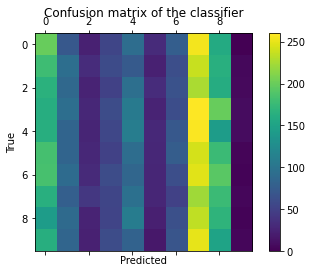

----------------------------------------------------------------------------------------------------
loss and acuuracy for test dataset
296/296 [==============================] - 81s 268ms/step - loss: 2.1411 - accuracy: 0.2302
result for test dataset: loss is 2.141146421432495, acuuracy is 0.23015202581882477
----------------------------------------------------------------------------------------------------
Precision: 0.10323053
Recall: 0.10325169
Accuracy: 0.10325169
F1 Score(micro): 0.10325169
----------------------------------------------------------------------------------------------------


In [ ]:


# labels = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
cm = metrics.confusion_matrix(list(Y_test_labels), list(Y_pred_labels) )
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels( labels)
# ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('-'*100)
print('loss and acuuracy for test dataset')
loss, accuracy = model.evaluate(test_dataset)
print('result for test dataset: loss is {}, acuuracy is {}'.format(loss, accuracy))
print('-'*100)
print('Precision: %.8f' % metrics.precision_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Recall: %.8f' % metrics.recall_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Accuracy: %.8f' % metrics.accuracy_score(Y_test_labels, Y_pred_labels))
print('F1 Score(micro): %.8f' % metrics.f1_score(Y_test_labels, Y_pred_labels,average= 'micro'))
print('-'*100)

## finetuning(Adam)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')   #introduced for farsi(link:https://www.youtube.com/watch?v=Gn8gB6CD0ak)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'input_ids', dtype= 'int32')
attention_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'attention_mask', dtype= 'int32')
bert_embeds = bert_model(input_ids, attention_mask = attention_masks)[1]
intermeiate_layer = tf.keras.layers.Dense(512, activation='relu', name = 'intermeiate_layer')(bert_embeds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(intermeiate_layer)
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
EPOCHS = 5
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = EPOCHS)

Epoch 1/5
2356/2356 [==============================] - 2007s 846ms/step - loss: 1.6813 - accuracy: 0.3998 - val_loss: 1.2543 - val_accuracy: 0.5689
Epoch 2/5
2356/2356 [==============================] - 1995s 847ms/step - loss: 1.2424 - accuracy: 0.5677 - val_loss: 1.0286 - val_accuracy: 0.6567
Epoch 3/5
2356/2356 [==============================] - 1995s 847ms/step - loss: 1.0124 - accuracy: 0.6512 - val_loss: 0.9051 - val_accuracy: 0.6935
Epoch 4/5
2356/2356 [==============================] - 1997s 848ms/step - loss: 0.8383 - accuracy: 0.7149 - val_loss: 0.8587 - val_accuracy: 0.7195
Epoch 5/5
2356/2356 [==============================] - 1994s 846ms/step - loss: 0.6902 - accuracy: 0.7652 - val_loss: 0.7653 - val_accuracy: 0.7509


In [ ]:
model.save('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_b.h5') 

#### evaluation results

In [ ]:
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_b.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [ ]:
preds = model.predict(test_dataset)
Y_pred_labels = preds.argmax(axis=1)
data, labels = tuple(zip(*test_dataset))
Y_test=[]
for i in range(len(labels)):
  for j in range(32):
    Y_test.append(labels[i][j])


Y_test_labels=np.zeros_like(Y_pred_labels)
ind=0
for t in Y_test:
  Y_test_labels[ind] = (t.numpy()).argmax()
  ind+=1

296/296 [==============================] - 83s 268ms/step


[[ 92  95  78 106  95  48 106  97  79 144]
 [ 90 104  90 116  92  56 104  88 113 113]
 [132 102  67  99  95  60 114 116  92 118]
 [ 86 101  84  85  97  60 120  93  97 111]
 [ 89  95  73  78 118  54 108  91  97 108]
 [100  88  73  92  87  72 126 105  90 104]
 [ 77  99  79  98 111  36  94 106  85 129]
 [101  99  85  99  81  40  99 113 102 110]
 [ 82  95  81  84 118  60 103 125 105 120]
 [ 96 106  74  97 107  57 104  99 118 115]]


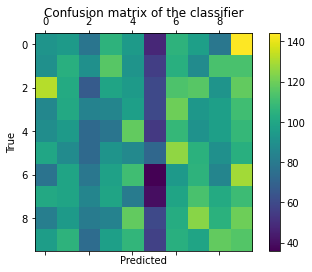

----------------------------------------------------------------------------------------------------
loss and acuuracy for test dataset
296/296 [==============================] - 82s 270ms/step - loss: 0.8997 - accuracy: 0.7042
result for test dataset: loss is 0.8997077941894531, acuuracy is 0.7041807174682617
----------------------------------------------------------------------------------------------------
Precision: 0.10290900
Recall: 0.10187922
Accuracy: 0.10187922
F1 Score(micro): 0.10187922
----------------------------------------------------------------------------------------------------


In [ ]:
# labels = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
cm = metrics.confusion_matrix(list(Y_test_labels), list(Y_pred_labels) )
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels( labels)
# ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('-'*100)
print('loss and acuuracy for test dataset')
loss, accuracy = model.evaluate(test_dataset)
print('result for test dataset: loss is {}, acuuracy is {}'.format(loss, accuracy))
print('-'*100)
print('Precision: %.8f' % metrics.precision_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Recall: %.8f' % metrics.recall_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Accuracy: %.8f' % metrics.accuracy_score(Y_test_labels, Y_pred_labels))
print('F1 Score(micro): %.8f' % metrics.f1_score(Y_test_labels, Y_pred_labels,average= 'micro'))
print('-'*100)

## finetuning(SGD)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')   #introduced for farsi(link:https://www.youtube.com/watch?v=Gn8gB6CD0ak)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_ids = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'input_ids', dtype= 'int32')
attention_masks = tf.keras.layers.Input(shape=(MAX_LENGTH,), name = 'attention_mask', dtype= 'int32')
bert_embeds = bert_model(input_ids, attention_mask = attention_masks)[1]
intermeiate_layer = tf.keras.layers.Dense(512, activation='relu', name = 'intermeiate_layer')(bert_embeds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name = 'output_layer')(intermeiate_layer)
model = tf.keras.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=2e-5, clipnorm=1.0)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
EPOCHS = 5
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = EPOCHS)

Epoch 1/5
2356/2356 [==============================] - 1816s 771ms/step - loss: 2.3232 - accuracy: 0.1015 - val_loss: 2.3081 - val_accuracy: 0.1050
Epoch 2/5
2356/2356 [==============================] - 1813s 769ms/step - loss: 2.3068 - accuracy: 0.1068 - val_loss: 2.3009 - val_accuracy: 0.1104
Epoch 3/5
2356/2356 [==============================] - 1814s 770ms/step - loss: 2.3014 - accuracy: 0.1111 - val_loss: 2.2955 - val_accuracy: 0.1180
Epoch 4/5
2356/2356 [==============================] - 1814s 770ms/step - loss: 2.2963 - accuracy: 0.1166 - val_loss: 2.2879 - val_accuracy: 0.1273
Epoch 5/5
2356/2356 [==============================] - 1812s 769ms/step - loss: 2.2894 - accuracy: 0.1265 - val_loss: 2.2815 - val_accuracy: 0.1371


In [ ]:
model.save('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_c.h5') 

#### evaluation results

In [ ]:
# loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_c.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [ ]:
preds = model.predict(test_dataset)
Y_pred_labels = preds.argmax(axis=1)
data, labels = tuple(zip(*test_dataset))
Y_test=[]
for i in range(len(labels)):
  for j in range(32):
    Y_test.append(labels[i][j])


Y_test_labels=np.zeros_like(Y_pred_labels)
ind=0
for t in Y_test:
  Y_test_labels[ind] = (t.numpy()).argmax()
  ind+=1

296/296 [==============================] - 80s 257ms/step


[[ 34 250  57  36  87  97  82  34 237  27]
 [ 35 250  52  40  91  86  59  20 274  33]
 [ 29 238  51  49  91 105  72  17 257  33]
 [ 43 229  41  38 113 109  70  19 259  41]
 [ 39 219  58  35  95  98  81  24 246  33]
 [ 33 231  60  36 108  98  73  30 276  26]
 [ 34 224  47  51 101  98  74  21 240  45]
 [ 28 213  67  38 123 110  66  21 262  33]
 [ 24 229  45  50 100 121  70  15 268  36]
 [ 39 197  57  41  92 108  73  23 266  38]]


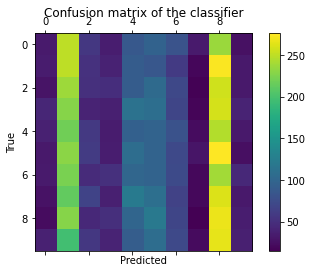

----------------------------------------------------------------------------------------------------
loss and acuuracy for test dataset
296/296 [==============================] - 79s 259ms/step - loss: 2.2790 - accuracy: 0.1428
result for test dataset: loss is 2.2790355682373047, acuuracy is 0.14284205436706543
----------------------------------------------------------------------------------------------------
Precision: 0.09973290
Recall: 0.10209037
Accuracy: 0.10209037
F1 Score(micro): 0.10209037
----------------------------------------------------------------------------------------------------


In [ ]:


# labels = ['amir','attar', 'bahar', 'farrokhi', 'ferdousi', 'hafez','feyz',  'parvin', 'saadi',  'vahshi']
cm = metrics.confusion_matrix(list(Y_test_labels), list(Y_pred_labels) )
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# ax.set_xticklabels( labels)
# ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print('-'*100)
print('loss and acuuracy for test dataset')
loss, accuracy = model.evaluate(test_dataset)
print('result for test dataset: loss is {}, acuuracy is {}'.format(loss, accuracy))
print('-'*100)
print('Precision: %.8f' % metrics.precision_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Recall: %.8f' % metrics.recall_score(Y_test_labels, Y_pred_labels,average= 'weighted'))
print('Accuracy: %.8f' % metrics.accuracy_score(Y_test_labels, Y_pred_labels))
print('F1 Score(micro): %.8f' % metrics.f1_score(Y_test_labels, Y_pred_labels,average= 'micro'))
print('-'*100)

In [ ]:
#### Perplexity

## Perplexity

In [42]:
!pip install keras_nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 114.0 MB/s eta 0:00:00


In [43]:
import keras_nlp

In [63]:
# perplexity = keras_nlp.metrics.Perplexity(name="perplexity")
perplexity = keras_nlp.metrics.Perplexity(from_logits=False, mask_token_id=0, dtype=None, name="perplexity")

In [54]:
loaded_model_a = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_a', custom_objects={"TFBertModel": transformers.TFBertModel})
loaded_model_b= tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_b.h5', custom_objects={"TFBertModel": transformers.TFBertModel}) 
loaded_model_c = tf.keras.models.load_model('/content/drive/MyDrive/deep_learning_hws/HWs/4/P3/model_c.h5', custom_objects={"TFBertModel": transformers.TFBertModel})

In [57]:
preds_a = loaded_model_a.predict(final_my_1000_samples)
preds_b = loaded_model_b.predict(final_my_1000_samples)
preds_c = loaded_model_c.predict(final_my_1000_samples)

Y_pred_labels = preds_c.argmax(axis=1)
data, labels = tuple(zip(*final_my_1000_samples))
Y_test=[]
for i in range(len(labels)):
  for j in range(32):
    Y_test.append(labels[i][j])


Y_test_labels=np.zeros_like(Y_pred_labels)
ind=0
for t in Y_test:
  Y_test_labels[ind] = (t.numpy()).argmax()
  ind+=1

preds_a = np.reshape(preds_a,(32,31,10))
preds_b = np.reshape(preds_b,(32,31,10))
preds_c = np.reshape(preds_c,(32,31,10))

Y_test_labels = np.reshape([Y_test_labels],((32,31)))

31/31 [==============================] - 8s 270ms/step


In [ ]:
perplexity_a = perplexity(Y_test_labels, preds_a)
perplexity_b = perplexity(Y_test_labels, preds_b)
perplexity_c = perplexity(Y_test_labels, preds_c)

In [58]:
print("perplexity_a(freezed_bert) is {}, perplexity_b(finetuning_adam) is {} and perplexity_b(finetuning_sgd) is {}".format(perplexity_a.numpy(), perplexity_b.numpy(), perplexity_c.numpy()))

perplexity_a(freezed_bert) is 20.025169372558594, perplexity_b(finetuning_adam) is 29.091941833496094 and perplexity_b(finetuning_sgd) is 24.44976234436035
